# All Imports

In [1]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.transforms as T
import cv2,re

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# Variables

In [2]:
IMAGE_FILE = 'test.jpg'
MODEL_PATH = 'pose_resnet_50_256x256.pth.tar'


POSE_PAIRS = [
# UPPER BODY
              [9, 8],
              [8, 7],
              [7, 6],

# LOWER BODY
              [6, 2],
              [2, 1],
              [1, 0],

              [6, 3],
              [3, 4],
              [4, 5],

# ARMS
              [7, 12],
              [12, 11],
              [11, 10],

              [7, 13],
              [13, 14],
              [14, 15]
]

JOINTS = ['0 - r ankle', '1 - r knee', '2 - r hip', '3 - l hip', '4 - l knee', '5 - l ankle', '6 - pelvis', '7 - thorax', '8 - upper neck', '9 - head top', '10 - r wrist', '11 - r elbow', '12 - r shoulder', '13 - l shoulder', '14 - l elbow', '15 - l wrist']
JOINTS = [re.sub(r'[0-9]+|-', '', joint).strip().replace(' ', '-') for joint in JOINTS]

# Transformed Image:

In [3]:
image = Image.open(IMAGE_FILE)
image = image.convert('RGB')
#plt.imshow(image)

transform = T.Compose([
                       T.Resize((256, 256)),
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                       ])

"""Transform the image for the model"""

tr_img = transform(image)
print('### Transformed Image size : {}'.format(tr_img.shape))

### Transformed Image size : torch.Size([3, 256, 256])


# Load quantized model and compute Prediction

In [4]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("simple_pose_estimation.quantized.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tr_img.unsqueeze(0))}
ort_outs = ort_session.run(None, ort_inputs)

np.array(ort_outs).shape

ort_outs = np.array(ort_outs[0][0])


In [5]:
ort_outs.shape

(16, 64, 64)

In [8]:
THRESHOLD = 0.8
(OUT_HEIGHT, OUT_WIDTH) = (64,64)
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = np.array(image) #cv2.imread(IMAGE_FILE) 
print(type(image_p))
print(type(image))
pose_layers = ort_outs

<class 'numpy.ndarray'>
<class 'PIL.Image.Image'>


In [9]:
IMAGE_FILE

'test.jpg'

In [10]:
from operator import itemgetter
get_keypoints = lambda pose_layers: map(itemgetter(1, 3), [cv2.minMaxLoc(pose_layer) for pose_layer in pose_layers])

key_points = list(get_keypoints(pose_layers=pose_layers))

print(key_points)


is_joint_plotted = [False for i in range(len(JOINTS))]

print(is_joint_plotted)

[(0.8831915855407715, (27, 58)), (0.9483209848403931, (28, 45)), (0.8818885684013367, (28, 31)), (0.935930073261261, (35, 31)), (0.9054384231567383, (36, 45)), (0.9666586518287659, (35, 58)), (0.9112903475761414, (32, 31)), (0.9619202613830566, (32, 13)), (0.910224199295044, (32, 10)), (0.9370672702789307, (32, 1)), (0.5864725708961487, (19, 29)), (0.8631244897842407, (20, 20)), (0.8808460831642151, (26, 13)), (0.9062439799308777, (38, 13)), (0.8871482014656067, (45, 21)), (0.7365853190422058, (45, 29))]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [11]:
for pose_pair in POSE_PAIRS:
    from_j, to_j = pose_pair

    from_thr, (from_x_j, from_y_j) = key_points[from_j]
    to_thr, (to_x_j, to_y_j) = key_points[to_j]
    
    IMG_HEIGHT, IMG_WIDTH, _ = image_p.shape

    from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
    from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

    from_x_j, to_x_j = int(from_x_j), int(to_x_j)
    from_y_j, to_y_j = int(from_y_j), int(to_y_j)

    if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
        # this is a joint
        cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[from_j] = True

    if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
        # this is a joint
        cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[to_j] = True

    if from_thr > THRESHOLD and to_thr > THRESHOLD:
        # this is a joint connection, plot a line
        cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 3)

### HPE Image shape is : (600, 600, 3)


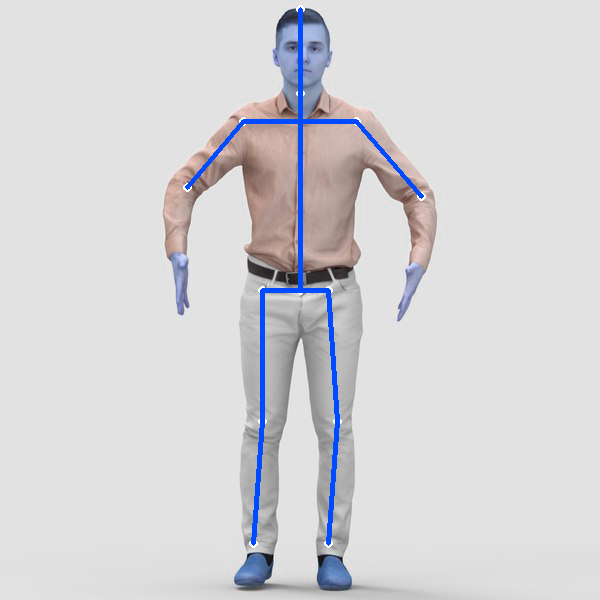

In [12]:
"""Pretty similar results !? eh ?"""
print('### HPE Image shape is : {}'.format(image_p.shape))
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))